In [1]:
import ROOT
import warnings

import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate, stats
from lmfit import Parameters, minimize

from scipy.optimize import curve_fit 
from tqdm import tqdm

from scipy.stats import norm, skewnorm
from scipy.signal import fftconvolve

warnings.filterwarnings('ignore')

# Width of the resonance in keV
width = 0.0067
width_err = 0.0005

# Boltzmann constant in keV/K
k = 8.617e-5

# Doppler effect
dopp = np.sqrt( 2 * 1.007 / 27 * 0.991 * k * ( 80 + 273 ) )

print( 'Doppler effect =', dopp )

Doppler effect = 0.04741874738287317


In [2]:
import stragg

import sys
stdout = sys.stdout

class Straggling:

    emGraph   = ROOT.TGraph( )
    gvGraph   = ROOT.TGraph( )
    vvGraph   = ROOT.TGraph( )
    demGraph  = ROOT.TGraph( )
    betaGraph = ROOT.TGraph( )
    xiGraph   = ROOT.TGraph( )
    kGraph    = ROOT.TGraph( )

    landau       = stragg.LandauFunction( )
    gauss        = stragg.GaussFunction( )
    vavilovAiry  = stragg.VavilovAiryFunction( )
    vavilovMoyal = stragg.VavilovMoyalFunction( )
    vavilovEdgew = stragg.VavilovEdgeworthFunction( )

    def __init__( self, element, energy ):
        self.energy = energy
        self.layer = stragg.Layer( element )
        self.layer_oxide = stragg.Layer( 8 )

    def get_stopping_power( self, energy ):
        return self.layer.EvaluateZiegler( energy )

    def prepare( self ):

        self.vvGraph.AddPoint( -100, 0 )
        self.vvGraph.AddPoint( 0, 0 )

        em   = self.energy
        gv   = 0
        vv   = 0
        dem  = 0
        xi   = 0
        k    = 0

        self.layer.setThicknessStep( 0.1 )
        self.layer_oxide.setThicknessStep( 0.1 )

        while ( (self.energy - em) < 50 ):

            de = self.energy - em
            if de < 0.0:
                deml_o = self.layer_oxide.GetDEML(em)
                gvl_o  = self.layer_oxide.GetGVL(em)
                vvl_o  = self.layer_oxide.GetVVL(em)
                kl_o   = self.layer_oxide.GetK(em)
                beta_o = self.layer_oxide.GetBeta(em)
                xilO  = self.layer_oxide.GetXi(em)
                deml_al = self.layer.GetDEML(em)
                gvl_al  = self.layer.GetGVL(em)
                vvl_al  = self.layer.GetVVL(em)
                kl_al   = self.layer.GetK(em)
                beta_al = self.layer.GetBeta(em)
                xil_al  = self.layer.GetXi(em)
                deml = 3 / 5 * deml_o + 2 / 5 * deml_al
                gvl  = 3 / 5 * gvl_o + 2 / 5 * gvl_al
                vvl  = 3 / 5 * vvl_o + 2 / 5 * vvl_al
                kl   = 3 / 5 * kl_o + 2 / 5 * kl_al
                beta = 3 / 5 * beta_o + 2 / 5 * beta_al
                xil  = 3 / 5 * xilO + 2 / 5 * xil_al

            else:
                deml = self.layer.GetDEML(em)
                gvl  = self.layer.GetGVL(em)
                vvl  = self.layer.GetVVL(em)
                kl   = self.layer.GetK(em)
                beta = self.layer.GetBeta(em)
                xil  = self.layer.GetXi(em)

            em  -= deml
            dem += deml
            k   += kl
            gv = np.sqrt(gv*gv + gvl*gvl)
            vv = np.sqrt(vv*vv + vvl*vvl)
            xi = xi + xil

            self.emGraph.AddPoint( dem, em )
            self.demGraph.AddPoint( dem, dem )
            self.kGraph.AddPoint( dem, k )
            self.gvGraph.AddPoint( dem, gv )
            self.vvGraph.AddPoint( dem, vv )
            self.xiGraph.AddPoint( dem, xi )
            self.betaGraph.AddPoint( dem, beta )

strag = Straggling( 13, 991 )
strag.prepare( )

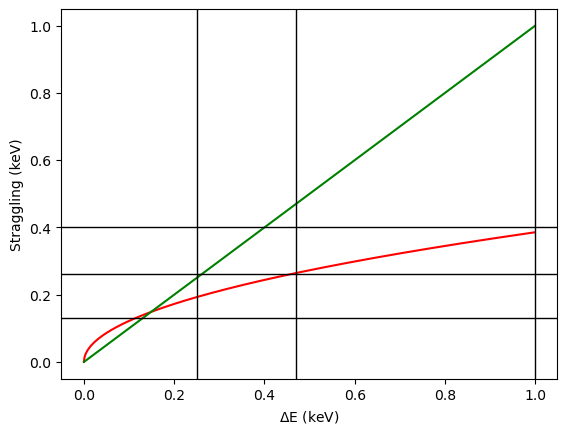

In [3]:
npoints = 1000

x = np.zeros( ( npoints ) )
y = np.zeros( ( npoints ) )
#y_oxygen = np.zeros( ( npoints ) )

for i in range( npoints ):
    x[i] = i * 0.001
    y[i] = strag.gvGraph.Eval( i * 0.001 )
    #y_oxygen[i] = strag_oxygen.gvGraph.Eval( i * 0.001 )

#plt.plot( x * 1000, y * 1000 )
#plt.plot( x, y_oxygen )

plt.ylabel( 'Straggling (keV)' )
plt.xlabel( r'$\Delta$E (keV)' )

def func( x, a ):
    return a * np.sqrt( x )

popt, pcov = curve_fit( func, x, y )

mod = func( x, *popt )

def straggling( x ):
    return popt[0] * np.sqrt( x ) / 1.2

plt.plot( x, straggling( x ), 'r' )
plt.plot( x, x, 'g' )
#plt.plot()

plt.axvline( 0.470, color='k', lw=1 )
plt.axhline( 0.260, color='k', lw=1 )

plt.axvline( 1.0, color='k', lw=1 )
plt.axhline( 0.4, color='k', lw=1 )

plt.axvline( 0.25, color='k', lw=1 )
plt.axhline( 0.13, color='k', lw=1 )

plt.show( )

Mean: 0.9046846127163187
Value: 982.71499564


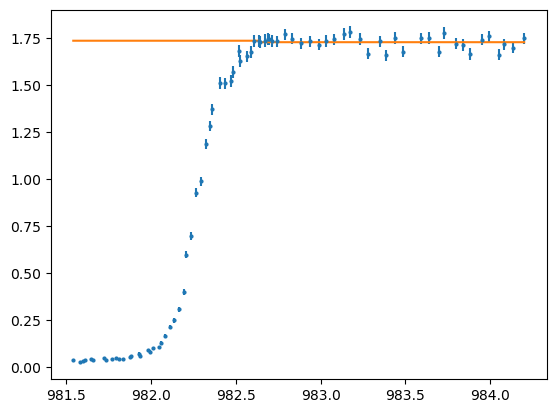

In [13]:
# Load the data skipping the header
data = np.loadtxt( 'data/Data_991_2023.txt', skiprows=1 )
x, obs, err = data[:,0], data[:,1], data[:,2]

# Find the closest point to the mean by interpolating
mean = (np.max( obs ) + np.min( obs )) / 2
value = np.interp( mean, obs, x )
print( 'Mean:', mean )
print( 'Value:', value )

grid = np.linspace( x.min(), x.max(), 1000 )
y = np.interp( grid, x, obs )

plt.errorbar( x, obs, yerr=err, fmt='o', markersize=2, label='Data' )
plt.plot( grid, y, label='Interpolated' )


In [5]:
def skewed_gaussian(x, mu=0, sigma_left=1, sigma_right=2, amplitude=1):
    """
    Skewed Gaussian with different standard deviations on each side of the mean.
    
    Parameters:
    - x : np.array or float
    - mu : float, mean of the distribution
    - sigma_left : float, standard deviation for x < mu
    - sigma_right : float, standard deviation for x >= mu
    - amplitude : float, peak height of the distribution
    
    Returns:
    - Gaussian value(s) at x
    """
    sigma = np.where(x < mu, sigma_left, sigma_right)
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma)**2)

def smooth_step_exp(x, k=60, x0=0.1):
    return 1 / (1 + np.exp(-k * (x - x0)))

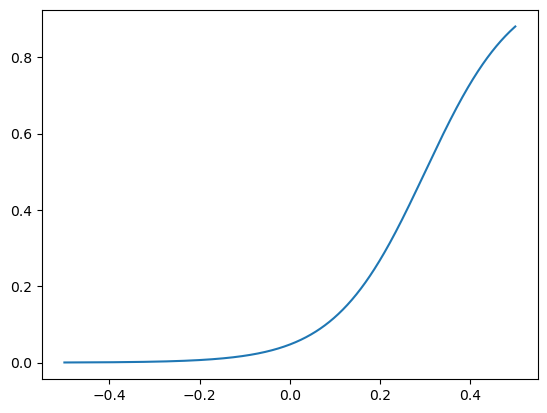

In [6]:
grid = np.linspace(-0.5, 0.5, 1000)

oxide_step = smooth_step_exp( grid, k=10, x0=0.3 )

plt.plot( grid, oxide_step, label='Smooth step function' )

plt.show( )

In [7]:
def sigma( de ):
    if( de > 0 ):
        return straggling( de )
    else:
        return 0

def gaussian( x, x0, s ):
    return ( 1. / ( np.sqrt(2.*np.pi) * s ) ) * np.exp( -(x - x0)**2 / ( s*s*2 ) )

def stoichiometry( x, theta ):
    nlayers = int( ( len( theta ) - 3 ) / 2 )
    if( nlayers == 1 ): return theta[3]
    else:
        norms = smooth_step_exp( x, k=10, x0=theta[4] )
        return theta[3] * ( 1 - norms ) + theta[5] * norms

def cross_section( x0, theta, de ):
    norm = stoichiometry( de, theta )
    return theta[1] / ( ( de - x0 )**2 + ( theta[1] / 2 )**2 ) * norm

def integrand( x, theta, x0 ):
    de, de_res = x0 - x, x0 - theta[2]
    
    # Get straggling
    s1 = sigma( de ) / theta[-1]
    s2 = np.sqrt( pow( theta[0], 2 ) + pow( dopp, 2 ) )
    stot = np.sqrt( s1**2 + s2**2 )

    # Get the integration range
    xmin, xmax, steps = de - 3 * stot, de + 3 * stot, 1000
    step = ( xmax - xmin ) / steps

    # Get grid for the integration
    array = np.linspace( xmin, xmax, steps )

    # For a Gaussian
    stragg_right = 0#s1
    sigma_right = np.sqrt( pow( s2, 2 ) + pow( stragg_right, 2 ) )
    stragg_left = 0#s1 * smooth_step_exp(de, k=0.8, x0=2)
    sigma_left = np.sqrt( pow( s2, 2 ) + pow( stragg_left, 2 ) )

    # For a straggling-skewed Gaussian (with Lewis effect)
    stragg_right = s1
    sigma_right = np.sqrt( pow( s2, 2 ) + pow( stragg_right, 2 ) )
    stragg_left = s1 * smooth_step_exp(de, k=5, x0=0.3)
    sigma_left = np.sqrt( pow( s2, 2 ) + pow( stragg_left, 2 ) )

    # For more realistic straggling
    #stragg_right = s1
    #sigma_right = np.sqrt( pow( s2, 2 ) + pow( stragg_right, 2 ) )
    #stragg_left = s1 * smooth_step_exp(de, k=1, x0=5)
    #sigma_left = np.sqrt( pow( s2, 2 ) + pow( stragg_left, 2 ) )

    # Create the convolution
    gauss = skewed_gaussian( array, mu=de, sigma_left=sigma_left, sigma_right=sigma_right, amplitude=1 )
    norm  = np.sum( gauss ) * step
    
    # Convolve
    conv = np.sum( gauss * cross_section( array, theta, de_res ) ) * step / norm

    return conv

def straggled_profile( x, theta ):
    y = np.zeros( shape=len( x ) )
    for idx in range( len( x ) ):
        xmin, xmax = x[idx] - 5, x[idx]
        nsteps = 100
        dx = np.abs( xmax - xmin ) / nsteps
        y[idx] = integrate.simpson( [ integrand( x_i, theta, x[idx] ) for x_i in np.linspace( xmin, xmax, nsteps) ], dx=dx )
    return y

def model( x, theta ):
    sign = straggled_profile( x, theta[:-1] )
    back = theta[-1]
    return sign + back

def chi2( theta ):
    theta = list( theta.valuesdict().values() )
    mod   = model( x, theta )
    res   = ( obs - mod ) / err
    print( "Chi2: {:10.4f}".format(np.sum(res**2)), end="\r" )
    return res

In [8]:
params = Parameters()
params.add('beam',     value=0.02,    vary=True)
params.add('width',    value=0.067,    vary=False)
params.add('edge1',    value=982.26,   vary=True)
params.add('height1',  value=0.10,    vary=True)
params.add('edge2',    value=0.35,     vary=False)
params.add('height2',  value=0.20,    vary=True)
params.add('scale',    value=1,        vary=False)
params.add('back1',    value=0,        vary=True)

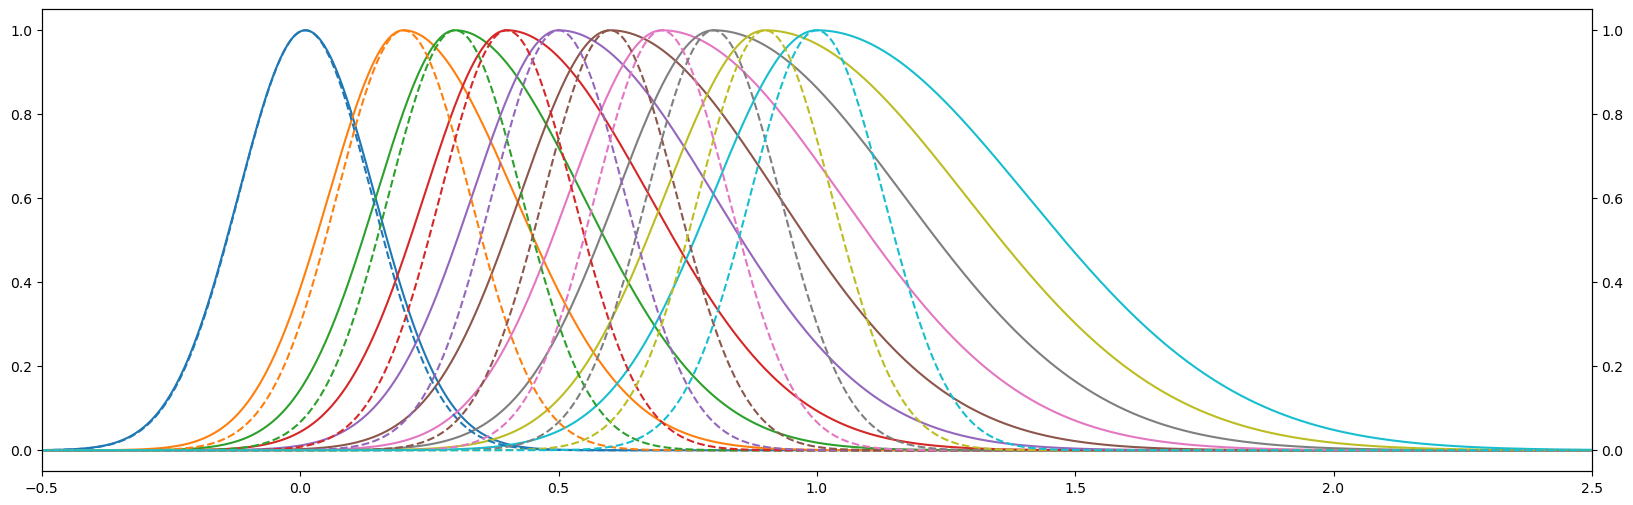

In [9]:
# Plot the skewed Gaussian
steps = [0.01, 0.2, 0.4, 0.6, 0.8, 1.0]
steps = [0.01, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

fig, ax1 = plt.subplots( figsize=(20, 6), dpi=100 )
ax2 = ax1.twinx()

for de in steps:
    s = straggling( de )
    
    # For Lewis effect
    sigma_right = np.sqrt( pow( 0.120, 2 ) + pow( dopp, 2 ) + pow( s, 2 ) )
    stragg = s * smooth_step_exp(de, k=5, x0=0.3) #smooth_step_exp(de, k=0.8, x0=2)
    sigma_left = np.sqrt( pow( 0.120, 2 ) + pow( dopp, 2 ) + pow( stragg, 2 ) )

    # For more realistic straggling
    sigma_right = np.sqrt( pow( 0.120, 2 ) + pow( dopp, 2 ) + pow( s, 2 ) )
    stragg = s * smooth_step_exp(de, k=0.1, x0=5) #smooth_step_exp(de, k=0.8, x0=2)
    sigma_left = np.sqrt( pow( 0.120, 2 ) + pow( dopp, 2 ) + pow( stragg, 2 ) )

    # For Gaussain
    #sigma_right = np.sqrt( pow( 0.120, 2 ) + pow( dopp, 2 ) )
    #sigma_left = np.sqrt( pow( 0.120, 2 ) + pow( dopp, 2 ) )

    # For Gaussian straggling
    #sigma_right = np.sqrt( pow( 0.120, 2 ) + pow( dopp, 2 ) + pow( s, 2 ) )
    #sigma_left = np.sqrt( pow( 0.120, 2 ) + pow( dopp, 2 ) + pow( s, 2 ) )

    # For no straggling
    sigma_no_stragg = np.sqrt( pow( 0.120, 2 ) + pow( dopp, 2 ) )

    x_vals = np.linspace( -0.5, 2.5, 1000 )
    y_vals = skewed_gaussian(x_vals, mu=de, sigma_left=sigma_left, sigma_right=sigma_right, amplitude=1)
    y_vals_no_stragg = skewed_gaussian(x_vals, mu=de, sigma_left=sigma_no_stragg, sigma_right=sigma_no_stragg, amplitude=1)

    norm = np.sum(y_vals) * (x_vals[1] - x_vals[0])

    reso = 1

    cross = cross_section( x_vals, [0.02, 0.067, de, 0.247, 1], reso )

    ax1.plot(x_vals, y_vals, label=f'Straggling: {de:.2f} keV')
    plt.plot(x_vals, y_vals_no_stragg, linestyle='--')

    #ax2.plot(x_vals + de - reso, cross * y_vals / norm, color='orange', linestyle='--', label='Cross-section')
    #ax2.plot(x_vals, cross, color='black', linestyle='--', label='Cross-section')

    ax1.set_xlim(-0.5, 2.5)

plt.show()

In [10]:
params = Parameters()
params.add('beam',     value=0.02,    vary=True)
params.add('width',    value=0.067,    vary=False)
params.add('edge1',    value=982.26,   vary=True)
params.add('height1',  value=0.10,    vary=True)
params.add('edge2',    value=0.35,     vary=False)
params.add('height2',  value=0.20,    vary=True)
params.add('scale',    value=1,        vary=False)
params.add('back1',    value=0,        vary=True)

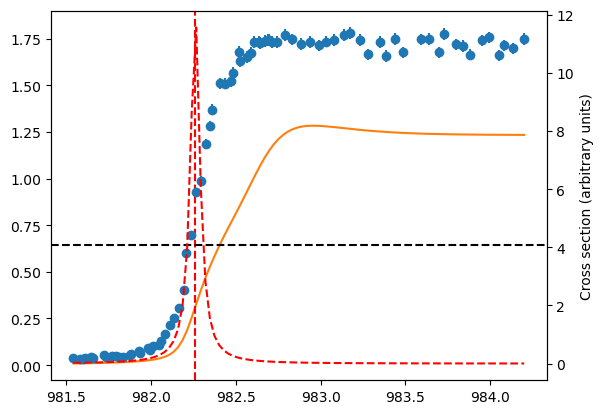

In [11]:
theta = list( params.valuesdict().values() )

grid = np.linspace( x.min( ), x.max( ), 100 )

mod = model( grid, theta )
cross = cross_section( grid, theta, theta[2] )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o' )
plt.plot( grid, mod, '-' )

plt.axvline( theta[2], color='r', linestyle='--', label='Resonance' )

ymin, ymax = min( mod ), max( mod )
ymean = ( ymin + ymax ) / 2
plt.axhline( ymean, color='k', linestyle='--', label='Mean' )

# Plot cross section on secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot( grid, cross, 'r--', label='Cross section' )
ax2.set_ylabel('Cross section (arbitrary units)')

#ax2.set_yscale('log')

plt.show( )

In [12]:
out = minimize(chi2, params, method="least_squares")

print(f'Nvars {out.nvarys}              Ndata {out.ndata}')
print(f'Chi2 {out.chisqr:11.5f}     Chi2 / Ndof {out.redchi:11.5f}')

theta, error = [], []
print("----------------------------------------")
print('Parameter    Value       Stderr')
for name, param in out.params.items():
    theta.append( param.value )
    error.append( param.stderr )
    if( param.stderr == None ): param.stderr = 0
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

Nvars 5              Ndata 77
Chi2   159.99053     Chi2 / Ndof     2.22209
----------------------------------------
Parameter    Value       Stderr
beam        0.03344     0.01423
width       0.06700     0.00000
edge1     982.24018     0.00744
height1     0.23317     0.00668
edge2       0.35000     0.00000
height2     0.27099     0.00136
scale       1.00000     0.00000
back1       0.01518     0.00213


In [13]:
# Sample the theta 1 with a gaussian of 0.02 and calculate the 1 sigma spread
nsamples = 100

samples = np.zeros( shape=(nsamples, len(grid)) )
for i in tqdm( range( nsamples ) ):
    theta_new = theta.copy()
    for k in range( len( theta ) ):
        # If fixed, skip
        if( error[k] == 0 ): continue
        theta_new[k] = np.random.normal( theta[k], error[k] )
    samples[i] = model( grid, theta_new )

mean = np.mean( samples, axis=0 )
std  = np.std( samples, axis=0 )

100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


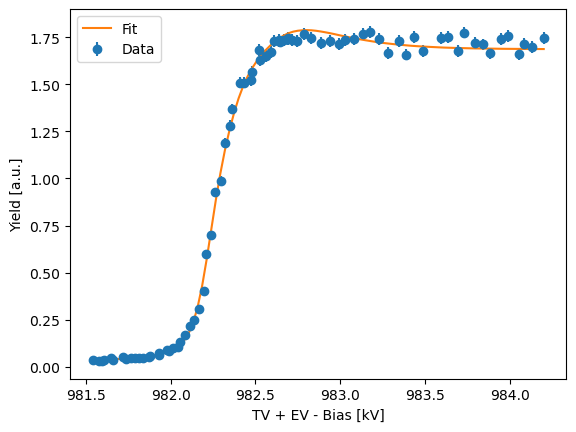

In [14]:
mod = model( grid, theta )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o', label="Data" )
plt.plot( grid, mod, '-', label="Fit" )
#plt.plot( grid, mean, '-', label="Fit" )
#plt.fill_between( grid, mean - std, mean + std, color='tab:orange', alpha=0.5 )

#plt.axvline( x=theta[2] - 0.27, color='r', linestyle='--', label="Edge" )

plt.legend( )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

#plt.text( 625, 6, r'$\chi ^2 _r$: {:10.4f}'.format( out.redchi ) )

plt.savefig( "results/Fit_991_2023.pdf" )

In [15]:
# Print curve to txt file
with open( "results/Fit_991_2023.txt", "w" ) as f:
    for i in range( len( grid ) ):
        f.write( "{:10.4f} {:10.10f}\n".format( grid[i], mod[i] ) )

In [16]:
# Load the data skipping the header
data = np.loadtxt( 'data/Data_991_2024.txt', skiprows=1 )
x, obs, err = data[:,0], data[:,1], data[:,2]

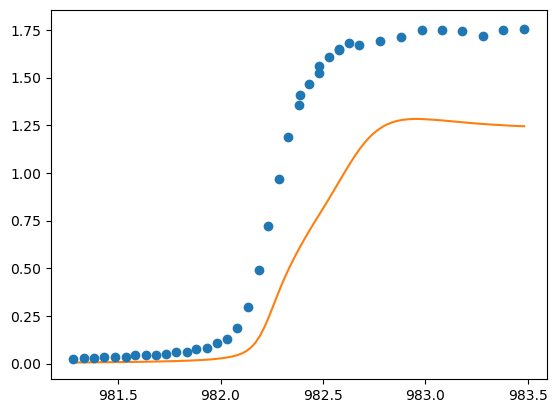

In [17]:
theta = list( params.valuesdict().values() )

grid = np.linspace( x.min( ), x.max( ), 100 )

mod = model( grid, theta )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o' )
plt.plot( grid, mod, '-' )

plt.show( )

In [18]:
out = minimize(chi2, params, method="least_squares")

print(f'Nvars {out.nvarys}              Ndata {out.ndata}')
print(f'Chi2 {out.chisqr:11.5f}     Chi2 / Ndof {out.redchi:11.5f}')

theta, error = [], []
print("----------------------------------------")
print('Parameter    Value       Stderr')
for name, param in out.params.items():
    theta.append( param.value )
    error.append( param.stderr )
    if( param.stderr == None ): param.stderr = 0
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

Nvars 5              Ndata 40
Chi2   246.03966     Chi2 / Ndof     7.02970
----------------------------------------
Parameter    Value       Stderr
beam        0.07448     0.00795
width       0.06700     0.00000
edge1     982.24739     0.00734
height1     0.23740     0.00620
edge2       0.35000     0.00000
height2     0.26851     0.00205
scale       1.00000     0.00000
back1       0.01791     0.00157


In [19]:
# Sample the theta 1 with a gaussian of 0.02 and calculate the 1 sigma spread
nsamples = 100

samples = np.zeros( shape=(nsamples, len(grid)) )
for i in tqdm( range( nsamples ) ):
    theta_new = theta.copy()
    for k in range( len( theta ) ):
        # If fixed, skip
        if( error[k] == 0 ): continue
        theta_new[k] = np.random.normal( theta[k], error[k] )
    samples[i] = model( grid, theta_new )

mean = np.mean( samples, axis=0 )
std  = np.std( samples, axis=0 )

100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


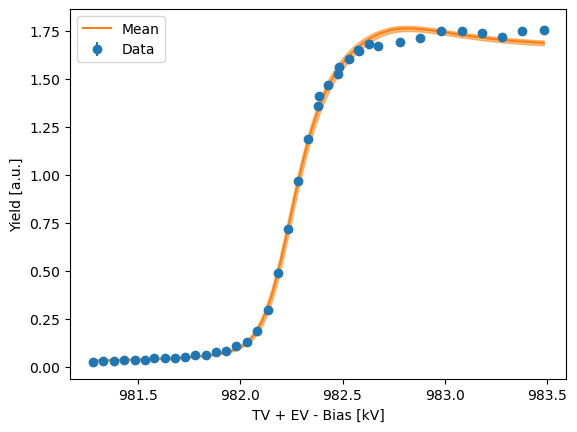

In [20]:
mod = model( grid, theta )

plt.errorbar( data[:, 0], data[:, 1], yerr=data[:, 2], fmt='o', label="Data" )
plt.plot( grid, mean, '-', label="Mean" )
plt.fill_between( grid, mean - std, mean + std, color='tab:orange', alpha=0.5 )

plt.legend( )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

#plt.text( 625, 6, r'$\chi ^2 _r$: {:10.4f}'.format( out.redchi ) )

plt.savefig( "results/Fit_991_2024.pdf" )

In [21]:
# Print curve to txt file
with open( "results/Fit_991_2024.txt", "w" ) as f:
    for i in range( len( grid ) ):
        f.write( "{:10.4f} {:10.10f}\n".format( grid[i], mod[i] ) )

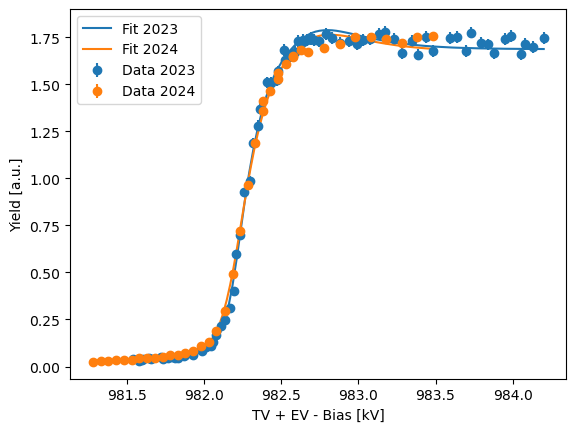

In [22]:
# Load all the fits
mod_2023 = np.loadtxt( "results/Fit_991_2023.txt", skiprows=1 )
mod_2024 = np.loadtxt( "results/Fit_991_2024.txt", skiprows=1 )

# Load all the data
data_2023 = np.loadtxt( 'data/Data_991_2023.txt', skiprows=1 )
data_2024 = np.loadtxt( 'data/Data_991_2024.txt', skiprows=1 )

# Plot the data
plt.errorbar( data_2023[:, 0], data_2023[:, 1], yerr=data_2023[:, 2], fmt='o', label="Data 2023", color='tab:blue' )
plt.errorbar( data_2024[:, 0], data_2024[:, 1], yerr=data_2024[:, 2], fmt='o', label="Data 2024", color='tab:orange' )

plt.plot( mod_2023[:, 0], mod_2023[:, 1], '-', label="Fit 2023", color='tab:blue' )
plt.plot( mod_2024[:, 0], mod_2024[:, 1], '-', label="Fit 2024", color='tab:orange' )

plt.xlabel( "TV + EV - Bias [kV]" )
plt.ylabel( "Yield [a.u.]" )

plt.legend( )
plt.savefig( "results/Fit_991.pdf" )